Building a Q&A Bot with OpenAI: A Step-by-Step Guide to Scraping Websites and Answer Questions

This tutorial presents a Python script that

crawls a website,
extracts the text from the webpages,
tokenizes the text, and
creates embeddings for each text (quick explanation on “embeddings” below).
It then uses OpenAI’s API to answer questions based on the embeddings of the text.

You will need to create your own API key in case you want to try it yourself.

This section of the code imports the necessary Python libraries for the script, including requests for sending HTTP requests, re for regular expressions, urllib.request for opening URLs, BeautifulSoup for parsing HTML and XML, deque for creating a queue, HTMLParser for parsing HTML, urlparse for parsing URLs, os for interacting with the operating system, pandas for working with dataframes, tiktoken for getting a tokenizer, and openai for creating embeddings and answering questions.

In [10]:
################################################################################
### Step 1
################################################################################

import requests
import re
import urllib.request
from bs4 import BeautifulSoup
from collections import deque
from html.parser import HTMLParser
from urllib.parse import urlparse
import os
import pandas as pd
import tiktoken
import openai
from openai.embeddings_utils import distances_from_embeddings
import numpy as np
from openai.embeddings_utils import distances_from_embeddings, cosine_similarity

# Regex pattern to match a URL
HTTP_URL_PATTERN = r'^http[s]*://.+'

# Define root domain to crawl
domain = "openai.com"
full_url = "https://openai.com/"

# Create a class to parse the HTML and get the hyperlinks
class HyperlinkParser(HTMLParser):
    def __init__(self):
        super().__init__()
        # Create a list to store the hyperlinks
        self.hyperlinks = []

    # Override the HTMLParser's handle_starttag method to get the hyperlinks
    def handle_starttag(self, tag, attrs):
        attrs = dict(attrs)

        # If the tag is an anchor tag and it has an href attribute, add the href attribute to the list of hyperlinks
        if tag == "a" and "href" in attrs:
            self.hyperlinks.append(attrs["href"])

Step 2
This section of the code defines a function called get_hyperlinks that takes a URL as input, tries to open the URL and read the HTML, and then parses the HTML to get hyperlinks. If the response is not HTML, it returns an empty list.

In [11]:
################################################################################
### Step 2
################################################################################

# Function to get the hyperlinks from a URL
def get_hyperlinks(url):
    
    # Try to open the URL and read the HTML
    try:
        # Open the URL and read the HTML
        with urllib.request.urlopen(url) as response:

            # If the response is not HTML, return an empty list
            if not response.info().get('Content-Type').startswith("text/html"):
                return []
            
            # Decode the HTML
            html = response.read().decode('utf-8')
    except Exception as e:
        print(e)
        return []

    # Create the HTML Parser and then Parse the HTML to get hyperlinks
    parser = HyperlinkParser()
    parser.feed(html)

    return parser.hyperlinks

Step 3

This section of the code defines a function called get_domain_hyperlinks that takes a domain and a URL as input and returns a list of hyperlinks from the URL that are within the same domain. If the hyperlink is a URL, it checks if it is within the same domain. If the hyperlink is not a URL, it checks if it is a relative link.

In [12]:
################################################################################
### Step 3
################################################################################

# Function to get the hyperlinks from a URL that are within the same domain
def get_domain_hyperlinks(local_domain, url):
    clean_links = []
    for link in set(get_hyperlinks(url)):
        clean_link = None

        # If the link is a URL, check if it is within the same domain
        if re.search(HTTP_URL_PATTERN, link):
            # Parse the URL and check if the domain is the same
            url_obj = urlparse(link)
            if url_obj.netloc == local_domain:
                clean_link = link

        # If the link is not a URL, check if it is a relative link
        else:
            if link.startswith("/"):
                link = link[1:]
            elif link.startswith("#") or link.startswith("mailto:"):
                continue
            clean_link = "https://" + local_domain + "/" + link

        if clean_link is not None:
            if clean_link.endswith("/"):
                clean_link = clean_link[:-1]
            clean_links.append(clean_link)

    # Return the list of hyperlinks that are within the same domain
    return list(set(clean_links))

Step 4
This section of the code defines a function called crawl that takes a URL as input, parses the URL to get the domain, creates a queue to store the URLs to crawl, creates a set to store the URLs that have already been seen (no duplicates), and creates a directory to store the text files. It then continues crawling until the queue is empty, saving the text from each URL to a text file, and getting the hyperlinks from each URL and adding them to the queue.

In [13]:
################################################################################
### Step 4
################################################################################

def crawl(url):
    # Parse the URL and get the domain
    local_domain = urlparse(url).netloc

    # Create a queue to store the URLs to crawl
    queue = deque([url])

    # Create a set to store the URLs that have already been seen (no duplicates)
    seen = set([url])

    # Create a directory to store the text files
    if not os.path.exists("text/"):
            os.mkdir("text/")

    if not os.path.exists("text/"+local_domain+"/"):
            os.mkdir("text/" + local_domain + "/")

    # Create a directory to store the csv files
    if not os.path.exists("processed"):
            os.mkdir("processed")

    # While the queue is not empty, continue crawling
    while queue:

        # Get the next URL from the queue
        url = queue.pop()
        print(url) # for debugging and to see the progress

        # Save text from the url to a <url>.txt file
        with open('text/'+local_domain+'/'+url[8:].replace("/", "_") + ".txt", "w", encoding="UTF-8") as f:

            # Get the text from the URL using BeautifulSoup
            soup = BeautifulSoup(requests.get(url).text, "html.parser")

            # Get the text but remove the tags
            text = soup.get_text()

            # If the crawler gets to a page that requires JavaScript, it will stop the crawl
            if ("You need to enable JavaScript to run this app." in text):
                print("Unable to parse page " + url + " due to JavaScript being required")
            
            # Otherwise, write the text to the file in the text directory
            f.write(text)

        # Get the hyperlinks from the URL and add them to the queue
        for link in get_domain_hyperlinks(local_domain, url):
            if link not in seen:
                queue.append(link)
                seen.add(link)

crawl(full_url)

https://openai.com/
https://openai.com/about
https://openai.com/about#content
https://openai.com/blog/openai-lp
https://openai.com/blog/learning-dexterity
https://openai.com/research?topics=domain-randomization
https://openai.com/research?topics=transformers
https://openai.com/research?topics=software-engineering
https://openai.com/research?topics=image-generation
https://openai.com/research?topics=computer-vision
https://openai.com/research/formal-math
https://openai.com/research/formal-math#content
https://openai.com/research?authors=stanislas-polu
https://openai.com/research?contentTypes=publication
https://openai.com/research?authors=jesse-michael-han
https://openai.com/research/efficient-training-of-language-models-to-fill-in-the-middle
https://openai.com/research?authors=nikolas-tezak
https://openai.com/research?authors=jerry-tworek
https://openai.com/research?authors=heewoo-jun
https://openai.com/research?authors=christine-mcleavey-payne
https://openai.com/research?authors=john-

Step 5

This section of the code defines a function called remove_newlines that takes a pandas Series object as input, replaces newlines with spaces, and returns the modified Series.

In [14]:
################################################################################
### Step 5
################################################################################

def remove_newlines(serie):
    serie = serie.str.replace('\n', ' ')
    serie = serie.str.replace('\\n', ' ')
    serie = serie.str.replace('  ', ' ')
    serie = serie.str.replace('  ', ' ')
    return serie

Step 6
This section of the code creates a list called texts to store the text files, gets all the text files in the text directory, opens each file, reads the text, omits the first 11 lines and the last 4 lines, replaces -, _, and #update with spaces, and appends the modified text to the list of texts. It then creates a dataframe from the list of texts, sets the text column to be the raw text with the newlines removed, and saves the dataframe as a CSV file.

In [15]:
################################################################################
### Step 6
################################################################################

# Create a list to store the text files
texts=[]

# Get all the text files in the text directory
for file in os.listdir("text/" + domain + "/"):

    # Open the file and read the text
    with open("text/" + domain + "/" + file, "r", encoding="UTF-8") as f:
        text = f.read()

        # Omit the first 11 lines and the last 4 lines, then replace -, _, and #update with spaces.
        texts.append((file[11:-4].replace('-',' ').replace('_', ' ').replace('#update',''), text))

# Create a dataframe from the list of texts
df = pd.DataFrame(texts, columns = ['fname', 'text'])

# Set the text column to be the raw text with the newlines removed
df['text'] = df.fname + ". " + remove_newlines(df.text)
df.to_csv('processed/scraped.csv')
df.head()

/tmp/ipykernel_22231/34857133.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  serie = serie.str.replace('\\n', ' ')


,fname,text
0,blog openai codex,blog openai codex. OpenAI Codex CloseSearch...
1,research summarizing books,research summarizing books. Summarizing books...
2,careers senior manager gtm operations#content,careers senior manager gtm operations#content....
3,blog openai five #theproblem,blog openai five #theproblem. OpenAI Five ...
4,research openai five defeats dota 2 world cham...,research openai five defeats dota 2 world cham...


Step 7

This section of the code loads a tokenizer and applies it to the text column of the dataframe to get the number of tokens for each row. It then creates a histogram of the number of tokens per row.

<Axes: >

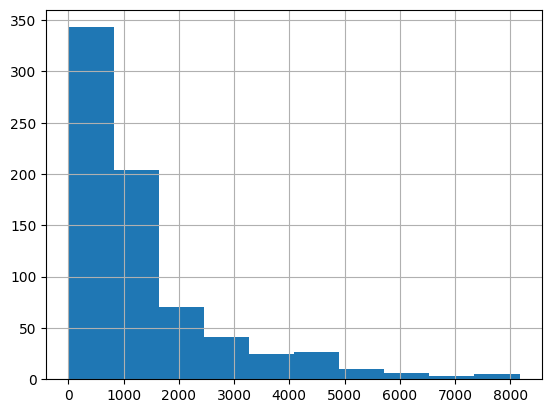

In [16]:
################################################################################
### Step 7
################################################################################

# Load the cl100k_base tokenizer which is designed to work with the ada-002 model
tokenizer = tiktoken.get_encoding("cl100k_base")

df = pd.read_csv('processed/scraped.csv', index_col=0)
df.columns = ['title', 'text']

# Tokenize the text and save the number of tokens to a new column
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))

# Visualize the distribution of the number of tokens per row using a histogram
df.n_tokens.hist()

Step 8

This section of the code defines a maximum number of tokens, creates a function called split_into_many that takes text and a maximum number of tokens as input and splits the text into chunks of a maximum number of tokens.

It then loops through the dataframe and either adds the text to the list of shortened texts or splits the text into chunks of a maximum number of tokens and adds the chunks to the list of shortened texts.

In [17]:
################################################################################
### Step 8
################################################################################

max_tokens = 500

# Function to split the text into chunks of a maximum number of tokens
def split_into_many(text, max_tokens = max_tokens):

    # Split the text into sentences
    sentences = text.split('. ')

    # Get the number of tokens for each sentence
    n_tokens = [len(tokenizer.encode(" " + sentence)) for sentence in sentences]
    
    chunks = []
    tokens_so_far = 0
    chunk = []

    # Loop through the sentences and tokens joined together in a tuple
    for sentence, token in zip(sentences, n_tokens):

        # If the number of tokens so far plus the number of tokens in the current sentence is greater 
        # than the max number of tokens, then add the chunk to the list of chunks and reset
        # the chunk and tokens so far
        if tokens_so_far + token > max_tokens:
            chunks.append(". ".join(chunk) + ".")
            chunk = []
            tokens_so_far = 0

        # If the number of tokens in the current sentence is greater than the max number of 
        # tokens, go to the next sentence
        if token > max_tokens:
            continue

        # Otherwise, add the sentence to the chunk and add the number of tokens to the total
        chunk.append(sentence)
        tokens_so_far += token + 1

    return chunks
    

shortened = []

# Loop through the dataframe
for row in df.iterrows():

    # If the text is None, go to the next row
    if row[1]['text'] is None:
        continue

    # If the number of tokens is greater than the max number of tokens, split the text into chunks
    if row[1]['n_tokens'] > max_tokens:
        shortened += split_into_many(row[1]['text'])
    
    # Otherwise, add the text to the list of shortened texts
    else:
        shortened.append( row[1]['text'] )

Step 9

This section of the code creates a new dataframe from the list of shortened texts, applies the tokenizer to the text column of the dataframe to get the number of tokens for each row, and creates a histogram of the number of tokens per row.

<Axes: >

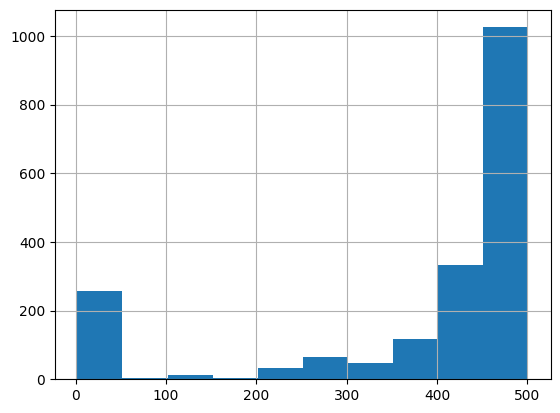

In [18]:
################################################################################
### Step 9
################################################################################

df = pd.DataFrame(shortened, columns = ['text'])
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))
df.n_tokens.hist()

Step 10

Step 10 involves using OpenAI’s language model to embed the text into vectors. This allows the model to analyze the text and make predictions based on its content. The openai.Embedding.create() function is used to create the embeddings, and they are saved in a new column in the DataFrame.



In [19]:
################################################################################
### Step 10
################################################################################

# Note that you may run into rate limit issues depending on how many files you try to embed
# Please check out our rate limit guide to learn more on how to handle this: https://platform.openai.com/docs/guides/rate-limits

df['embeddings'] = df.text.apply(lambda x: openai.Embedding.create(input=x, engine='text-embedding-ada-002')['data'][0]['embedding'])
df.to_csv('processed/embeddings.csv')
df.head()

AuthenticationError: No API key provided. You can set your API key in code using 'openai.api_key = <API-KEY>', or you can set the environment variable OPENAI_API_KEY=<API-KEY>). If your API key is stored in a file, you can point the openai module at it with 'openai.api_key_path = <PATH>'. You can generate API keys in the OpenAI web interface. See https://onboard.openai.com for details, or email support@openai.com if you have any questions.

Step 11

This involves loading the embeddings from the DataFrame and converting them to numpy arrays.

In [ ]:
################################################################################
### Step 11
################################################################################

df=pd.read_csv('processed/embeddings.csv', index_col=0)
df['embeddings'] = df['embeddings'].apply(eval).apply(np.array)

df.head()

Step 12

Step 12 includes the create_context() and answer_question() functions that use the embeddings to find the most similar context to a question and then answer it based on that context. These functions leverage OpenAI’s language models and the embeddings created in Step 10 to provide accurate and reliable answers. The create_context() function creates the context based on the question and the embeddings, while the answer_question() function uses the context and question to generate a response using OpenAI’s GPT-3 language model.



In [ ]:
################################################################################
### Step 12
################################################################################

def create_context(
    question, df, max_len=1800, size="ada"
):
    """
    Create a context for a question by finding the most similar context from the dataframe
    """

    # Get the embeddings for the question
    q_embeddings = openai.Embedding.create(input=question, engine='text-embedding-ada-002')['data'][0]['embedding']

    # Get the distances from the embeddings
    df['distances'] = distances_from_embeddings(q_embeddings, df['embeddings'].values, distance_metric='cosine')


    returns = []
    cur_len = 0

    # Sort by distance and add the text to the context until the context is too long
    for i, row in df.sort_values('distances', ascending=True).iterrows():
        
        # Add the length of the text to the current length
        cur_len += row['n_tokens'] + 4
        
        # If the context is too long, break
        if cur_len > max_len:
            break
        
        # Else add it to the text that is being returned
        returns.append(row["text"])

    # Return the context
    return "\n\n###\n\n".join(returns)

def answer_question(
    df,
    model="text-davinci-003",
    question="Am I allowed to publish model outputs to Twitter, without a human review?",
    max_len=1800,
    size="ada",
    debug=False,
    max_tokens=150,
    stop_sequence=None
):
    """
    Answer a question based on the most similar context from the dataframe texts
    """
    context = create_context(
        question,
        df,
        max_len=max_len,
        size=size,
    )
    # If debug, print the raw model response
    if debug:
        print("Context:\n" + context)
        print("\n\n")

    try:
        # Create a completions using the questin and context
        response = openai.Completion.create(
            prompt=f"Answer the question based on the context below, and if the question can't be answered based on the context, say \"I don't know\"\n\nContext: {context}\n\n---\n\nQuestion: {question}\nAnswer:",
            temperature=0,
            max_tokens=max_tokens,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
            stop=stop_sequence,
            model=model,
        )
        return response["choices"][0]["text"].strip()
    except Exception as e:
        print(e)
        return ""

Step 13
Step 13 provides an example of using the answer_question() function to answer two different questions. The first question is a simple one, while the second question requires more specific knowledge. This example demonstrates the versatility of the Q&A bot and its ability to answer a wide range of questions.

In [ ]:
################################################################################
### Step 13
################################################################################

print(answer_question(df, question="What day is it?", debug=False))

print(answer_question(df, question="What is our newest embeddings model?"))

Here’s a step-by-step guide on how to use it:

Install the required packages: The script uses several Python packages, including requests, BeautifulSoup, pandas, and openai. You can install these packages by running pip install -r requirements.txt in the directory where the script is located.
Set the website to scrape: In the script, you can specify the website to scrape by setting the domain and full_url variables in Step 1. The domain variable should be the root domain of the website (e.g., “example.com”), and the full_url variable should be the full URL of the website (e.g., “https://www.example.com/“).
Run the script: You can run the script in a Python environment by executing python script.py in the directory where the script is located.
Wait for the scraping to complete: The script will take some time to scrape the website and save the text files to disk. You can monitor the progress by looking at the console output.
Ask questions: After the scraping is complete, you can use the answer_question function in Step 12 to ask questions based on the scraped text. The function takes in a dataframe containing the scraped text, a question to ask, and several optional parameters. You can modify the question and other parameters to suit your needs.
Note that the script is intended as a demonstration of how to use OpenAI’s language models to answer questions based on scraped text, and may require modification to work with different websites or to answer different types of questions. It also requires an OpenAI API key to use. You can sign up for an API key on the OpenAI website.